# Sacred Cycles
*Simulating Menstrual-esque Cycles Using Injected Estrogen*

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sys

sys.path.insert(0, "../")
from transkit import pharma, fit, medications

In [2]:
t3_ec_cali = np.array([0.000000000, 0.246635358])
t2_ev_cali = np.array([0.000000000, 1.428689307])

calibrated_medications = dict(medications.medications)
calibrated_medications["ec"] = pharma.calibratedDoseResponse(
    calibrated_medications["ec"],
    t3_ec_cali)
calibrated_medications["ev"] = pharma.calibratedDoseResponse(
    calibrated_medications["ev"],
    t2_ev_cali)

# Optimization

This constructs an optimization problem solving for optimal injection doses and times to fit a desired blood level profile.

## Menstrual

In [3]:
def molarConcToMassConc(molar_conc, molar_weight):
    """Converts pmol/L to pg/mL for a substance of a particular molar weight.
    
    molar         Molar concentration in pmol/L [array like].
    molar_weight  Molar weight of substance in g/mol."""
    return molar_conc * molar_weight * 10**-3


e2_mol = 272.388 # g/mol

# Stricker2006, referenced from https://en.wikiversity.org/wiki/WikiJournal_of_Medicine/Reference_ranges_for_estradiol,_progesterone,_luteinizing_hormone_and_follicle-stimulating_hormone_during_the_menstrual_cycle
menstrual_e2 = molarConcToMassConc(np.array([118.42, 133.01, 133.17, 125.95, 134.65, 151.33, 159.48, 170.34, 195.9, 228.2, 269.07, 343.68, 477.27, 661.19, 914.84, 780.76, 320.59, 261.32, 338.94, 454.07, 499.49, 497.07, 531.14, 504.39, 499.18, 526.68, 350.65, 322.24, 229.7, 249.28, 150.0, 118.42, 118.42, 118.42, 118.42]),
                                   e2_mol)

menstrual_fit_start_t = pd.to_datetime("2020-01-01 12:00:00")
menstrual_fit_range_t = 6*7 - 1 + len(menstrual_e2) # 6 weeks to steady state, then the menstrual curve.
menstrual_fit_t  = pd.date_range(menstrual_fit_start_t,
                                 menstrual_fit_start_t + pd.to_timedelta(menstrual_fit_range_t, unit='D'),
                                 freq='1D')
menstrual_fit_e2 = np.append(np.full(6*7, menstrual_e2[0]), menstrual_e2)

menstrual_fit = pd.Series(menstrual_fit_e2, index=menstrual_fit_t)
menstrual_fit_results = fit.emptyResults()

### Estradiol Cypionate

Least squares figures out some real gymnastics to get this close, but EC doesn't decay quickly enough to mimic the big peak very well. I wonder if this result is still in range for some realistic cycle, even if it doesn't quite match the mean?

In [10]:
doses = pharma.createDosesCycle(
    "ec",
    menstrual_fit_range_t,
    '3D',
    start_date=menstrual_fit_start_t)
menstrual_fit_results["ec"] = fit.initializeFit(
    doses,
    calibrated_medications,
    menstrual_fit,
    dose_bounds=(0.0, 10.0),
    time_bounds=14*['fixed'] + (len(doses)-14)*['midpoints'],
    equal_doses=[doses.index[:13]], # All injections in the ramp-up to steady-state should be equal
    exclude_area=menstrual_fit[:doses.index[12]].index) # Only optimize starting from the first injection after steady-state
fit.runLeastSquares(
    menstrual_fit_results["ec"],
    max_nfev=35,
    ftol=1e-2,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.0858e+04                                    9.81e+04    
       1              2         1.8004e+04      4.29e+04       4.23e+00       1.54e+04    
       2              3         1.5551e+04      2.45e+03       1.04e+00       5.12e+03    
       3              4         1.3406e+04      2.15e+03       1.99e+00       9.90e+02    
       4              5         1.3321e+04      8.52e+01       9.08e-02       5.97e+03    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 6.0858e+04, final cost 1.3321e+04, first-order optimality 5.97e+03.


Optimized Doses:
                                     dose medication
2020-01-01 12:00:00.000000000      0.448         ec
2020-01-04 12:00:00.000000000      0.448         ec
2020-01-07 12:00:00.000000000      0.448         ec
2020-01-10 12:00:00.000000000      0.448         ec
2020-01-13 12:00:00.000000000      0.448         ec
2020-01-16 12:00:00.000000000      0.448         ec
2020-01-19 12:00:00.000000000      0.448         ec
2020-01-22 12:00:00.000000000      0.448         ec
2020-01-25 12:00:00.000000000      0.448         ec
2020-01-28 12:00:00.000000000      0.448         ec
2020-01-31 12:00:00.000000000      0.448         ec
2020-02-03 12:00:00.000000000      0.448         ec
2020-02-06 12:00:00.000000000      0.448         ec
2020-02-09 12:00:00.000000000      0.568         ec
2020-02-11 20:43:37.406236800      0.043         ec
2020-02-15 23:37:32.616969600      1.597         ec
2020-02-19 04:21:07.736256000      2.102         ec
2020-02-22 01:12:33.752505600      3.906      

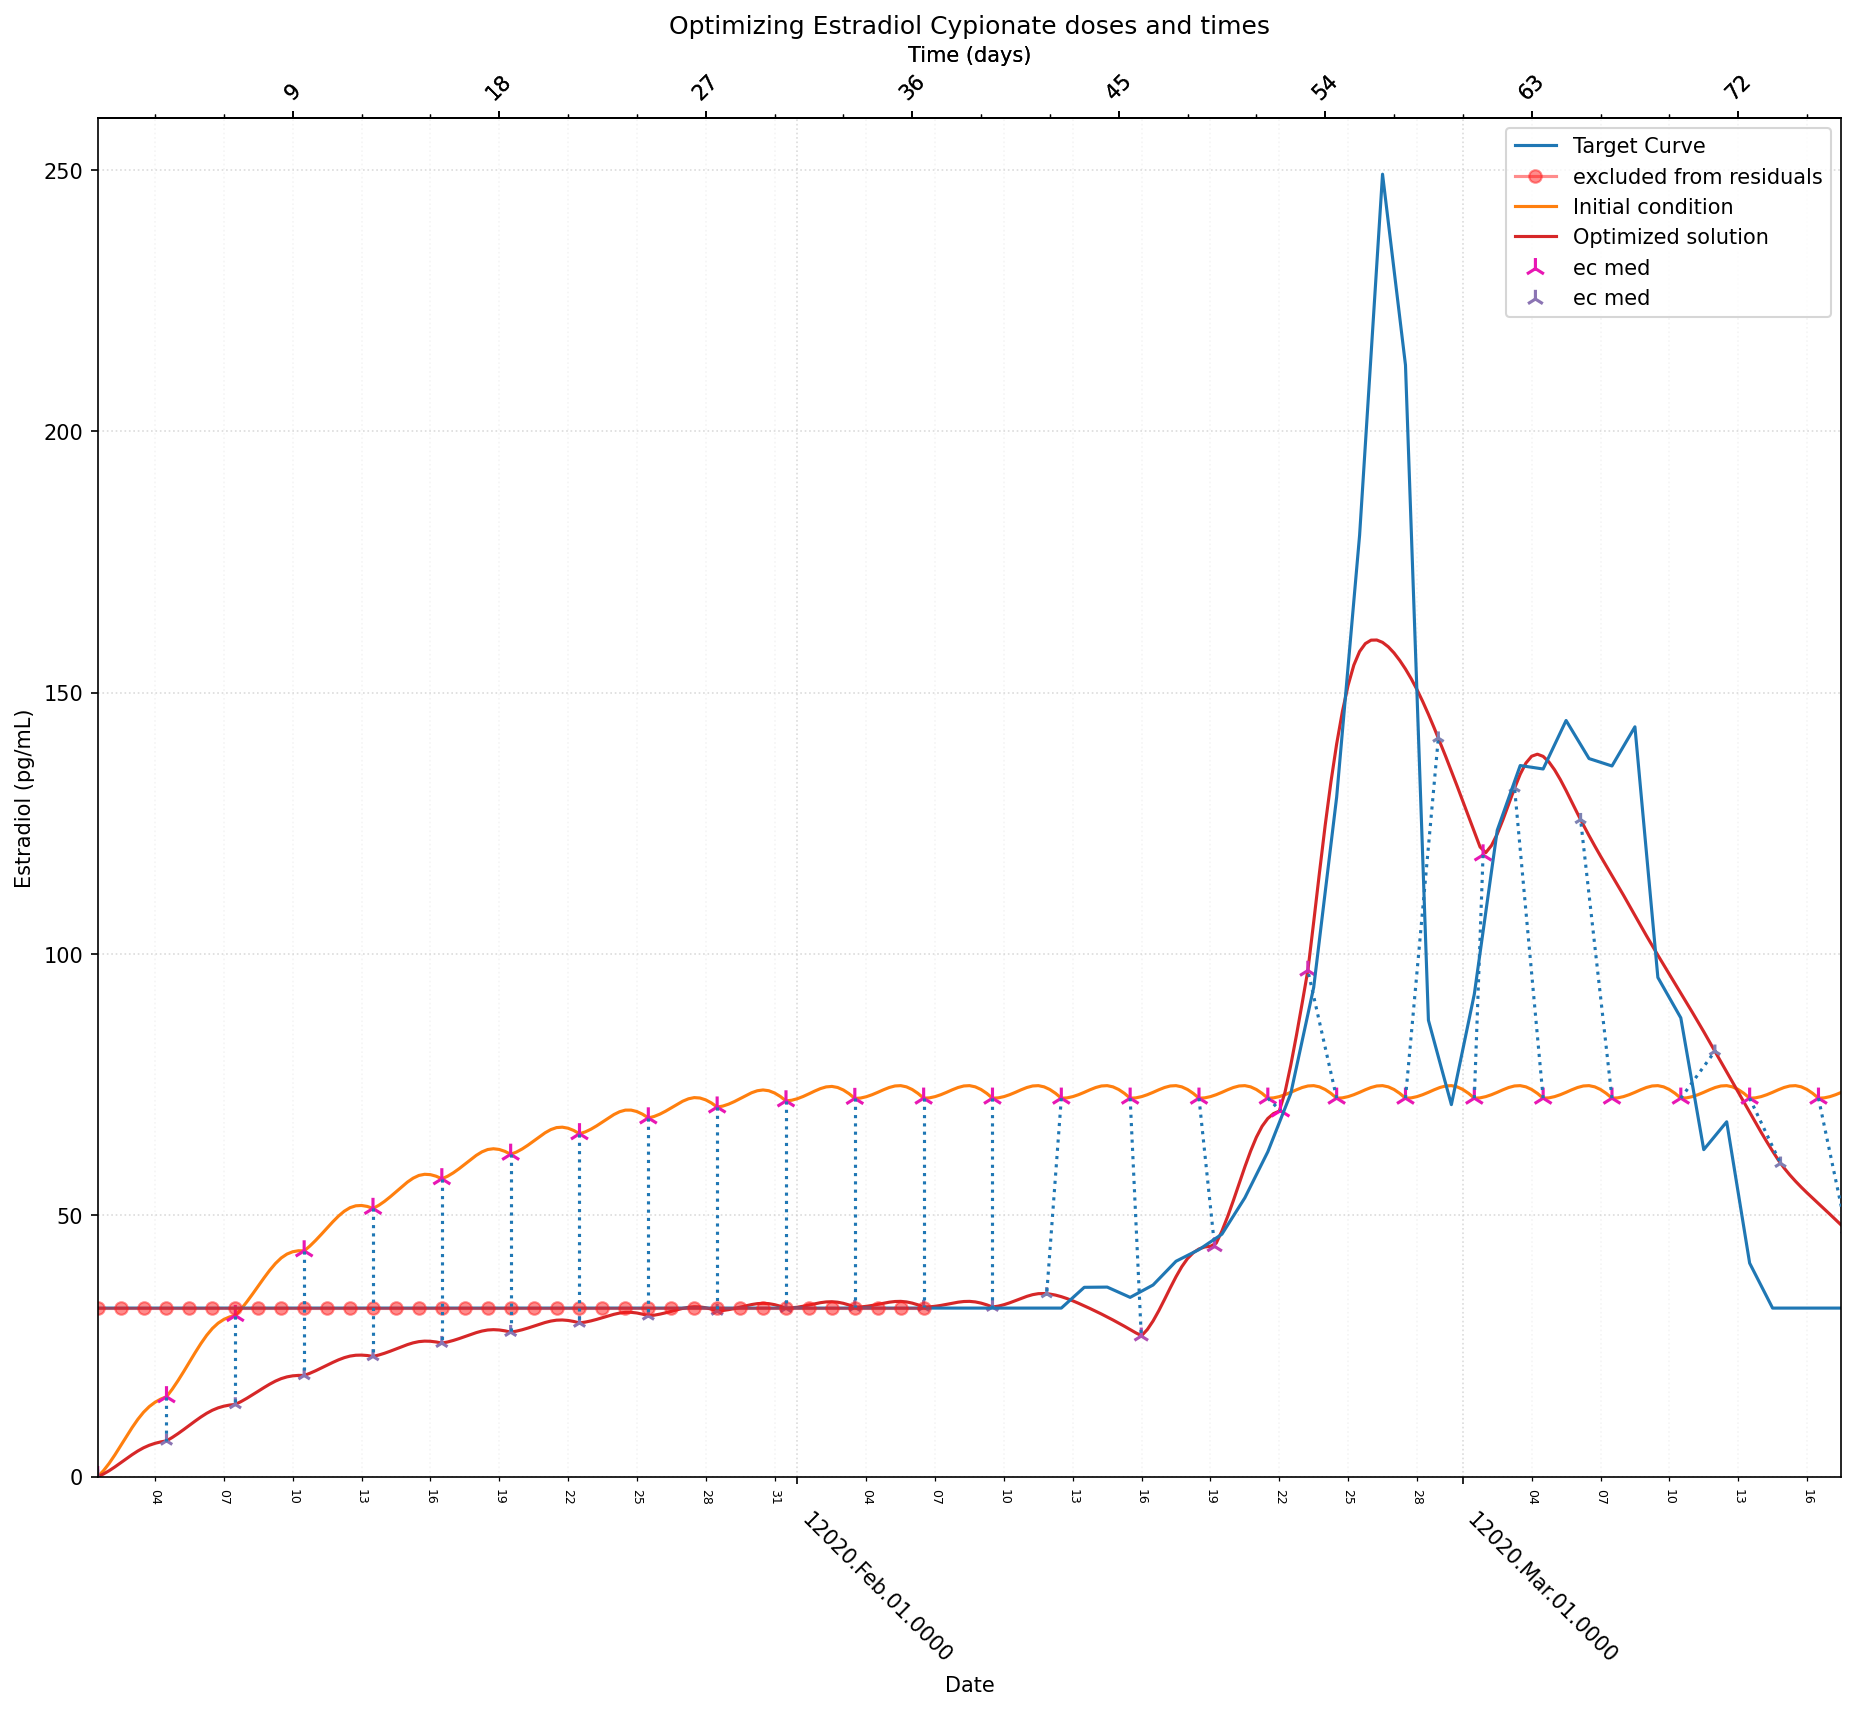

In [11]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Cypionate doses and times')
ax.set_ylim(bottom=0, top=260)
ax.set_yticks(range(0, 261, 50))
fit.plotOptimizationRun(fig, ax, menstrual_fit_results["ec"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Doses:\n", menstrual_fit_results["ec"]["doses_optim"])

### Estradiol Valerate

After all this work, it looks like EV can actually fit a realistic menstrual curve better than EC can. Wow! That's incredibly unexpected for me but I guess I was doing all of the curve fitting stuff at unrealistic time scales. The interesting bit here is that, because of the big intense spike in estradiol prior to ovulation, the decay rate of EC isn't able to keep up. EV, with it's big quick peak, and fast decay, is perfectly suited to mimicing that peak in estradiol.

Somatically it's almost like taking EV is like ovulating with every injection–and that actually resonates with my subjective experience pretty well. EV has a kind of dynamicism and responsiveness and punchiness to it. EC is much softer, pillowy, flowy, floaty. EV is unsurprisingly well suited to fitting to quicker, more dynamic curves; EC is better suited to gentler, more stable curves. They each have strengths. I have no idea how you'd get it prescribed, but I wonder if mixing medicines could work. Like using EC for most injections, but using EV for just around the big peak. Or maybe spiking with pills there. Once you've figured out the calibration for your body, a whole lot of magic is possible!

At realistic time scales there's a lot more to "stable levels" than just optimizing for constant e2 levels, that's for sure! I feel a bit sad and disappointed, and I wish I had done this piece with a real menstrual cycle curve much sooner. I am feeling a big expansion in my understanding of all this though, and how it fits together somatically. It's not what I was expecting, and that's really exciting! Laying it all out on a timeline is really important. I feel some inklings and sparking connections happening...

In [12]:
doses = pharma.createDosesCycle(
    "ev",
    menstrual_fit_range_t,
    '3D',
    start_date=menstrual_fit_start_t)
menstrual_fit_results["ev"] = fit.initializeFit(
    doses,
    calibrated_medications,
    menstrual_fit,
    dose_bounds=(0.0, 10.0),
    time_bounds=14*['fixed'] + (len(doses)-14)*['midpoints'],
    equal_doses=[doses.index[:14]], # All injections in the ramp-up to steady-state should be equal
    exclude_area=menstrual_fit[:doses.index[13]].index) # Only optimize starting from the first injection after steady-state
fit.runLeastSquares(
    menstrual_fit_results["ev"],
    max_nfev=35,
    ftol=1e-2,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.2308e+05                                    1.97e+05    
       1              2         8.3386e+04      3.40e+05       1.57e+00       4.91e+04    
       2              3         1.4675e+04      6.87e+04       1.02e+00       1.23e+04    
       3              4         2.9471e+03      1.17e+04       7.46e-01       1.49e+04    
       4              5         1.4718e+03      1.48e+03       3.98e-01       3.75e+03    
       5              6         1.2936e+03      1.78e+02       2.49e-01       3.21e+03    
       6              7         1.2430e+03      5.06e+01       1.98e-01       3.67e+03    
       7              8         1.2230e+03      2.00e+01       9.48e-02       4.42e+02    
       8              9         1.1716e+03      5.15e+01       2.32e-01       3.36e+02    
       9             10         1.1468e+03      2.47e+01       1.64e-01       1.76e+03    

Optimized Doses:
                                     dose medication
2020-01-01 12:00:00.000000000      0.145         ev
2020-01-04 12:00:00.000000000      0.145         ev
2020-01-07 12:00:00.000000000      0.145         ev
2020-01-10 12:00:00.000000000      0.145         ev
2020-01-13 12:00:00.000000000      0.145         ev
2020-01-16 12:00:00.000000000      0.145         ev
2020-01-19 12:00:00.000000000      0.145         ev
2020-01-22 12:00:00.000000000      0.145         ev
2020-01-25 12:00:00.000000000      0.145         ev
2020-01-28 12:00:00.000000000      0.145         ev
2020-01-31 12:00:00.000000000      0.145         ev
2020-02-03 12:00:00.000000000      0.145         ev
2020-02-06 12:00:00.000000000      0.145         ev
2020-02-09 12:00:00.000000000      0.145         ev
2020-02-12 14:16:27.124636800      0.169         ev
2020-02-15 19:10:59.301494400      0.199         ev
2020-02-18 21:49:28.371619200      0.280         ev
2020-02-22 00:06:01.643788800      0.578      

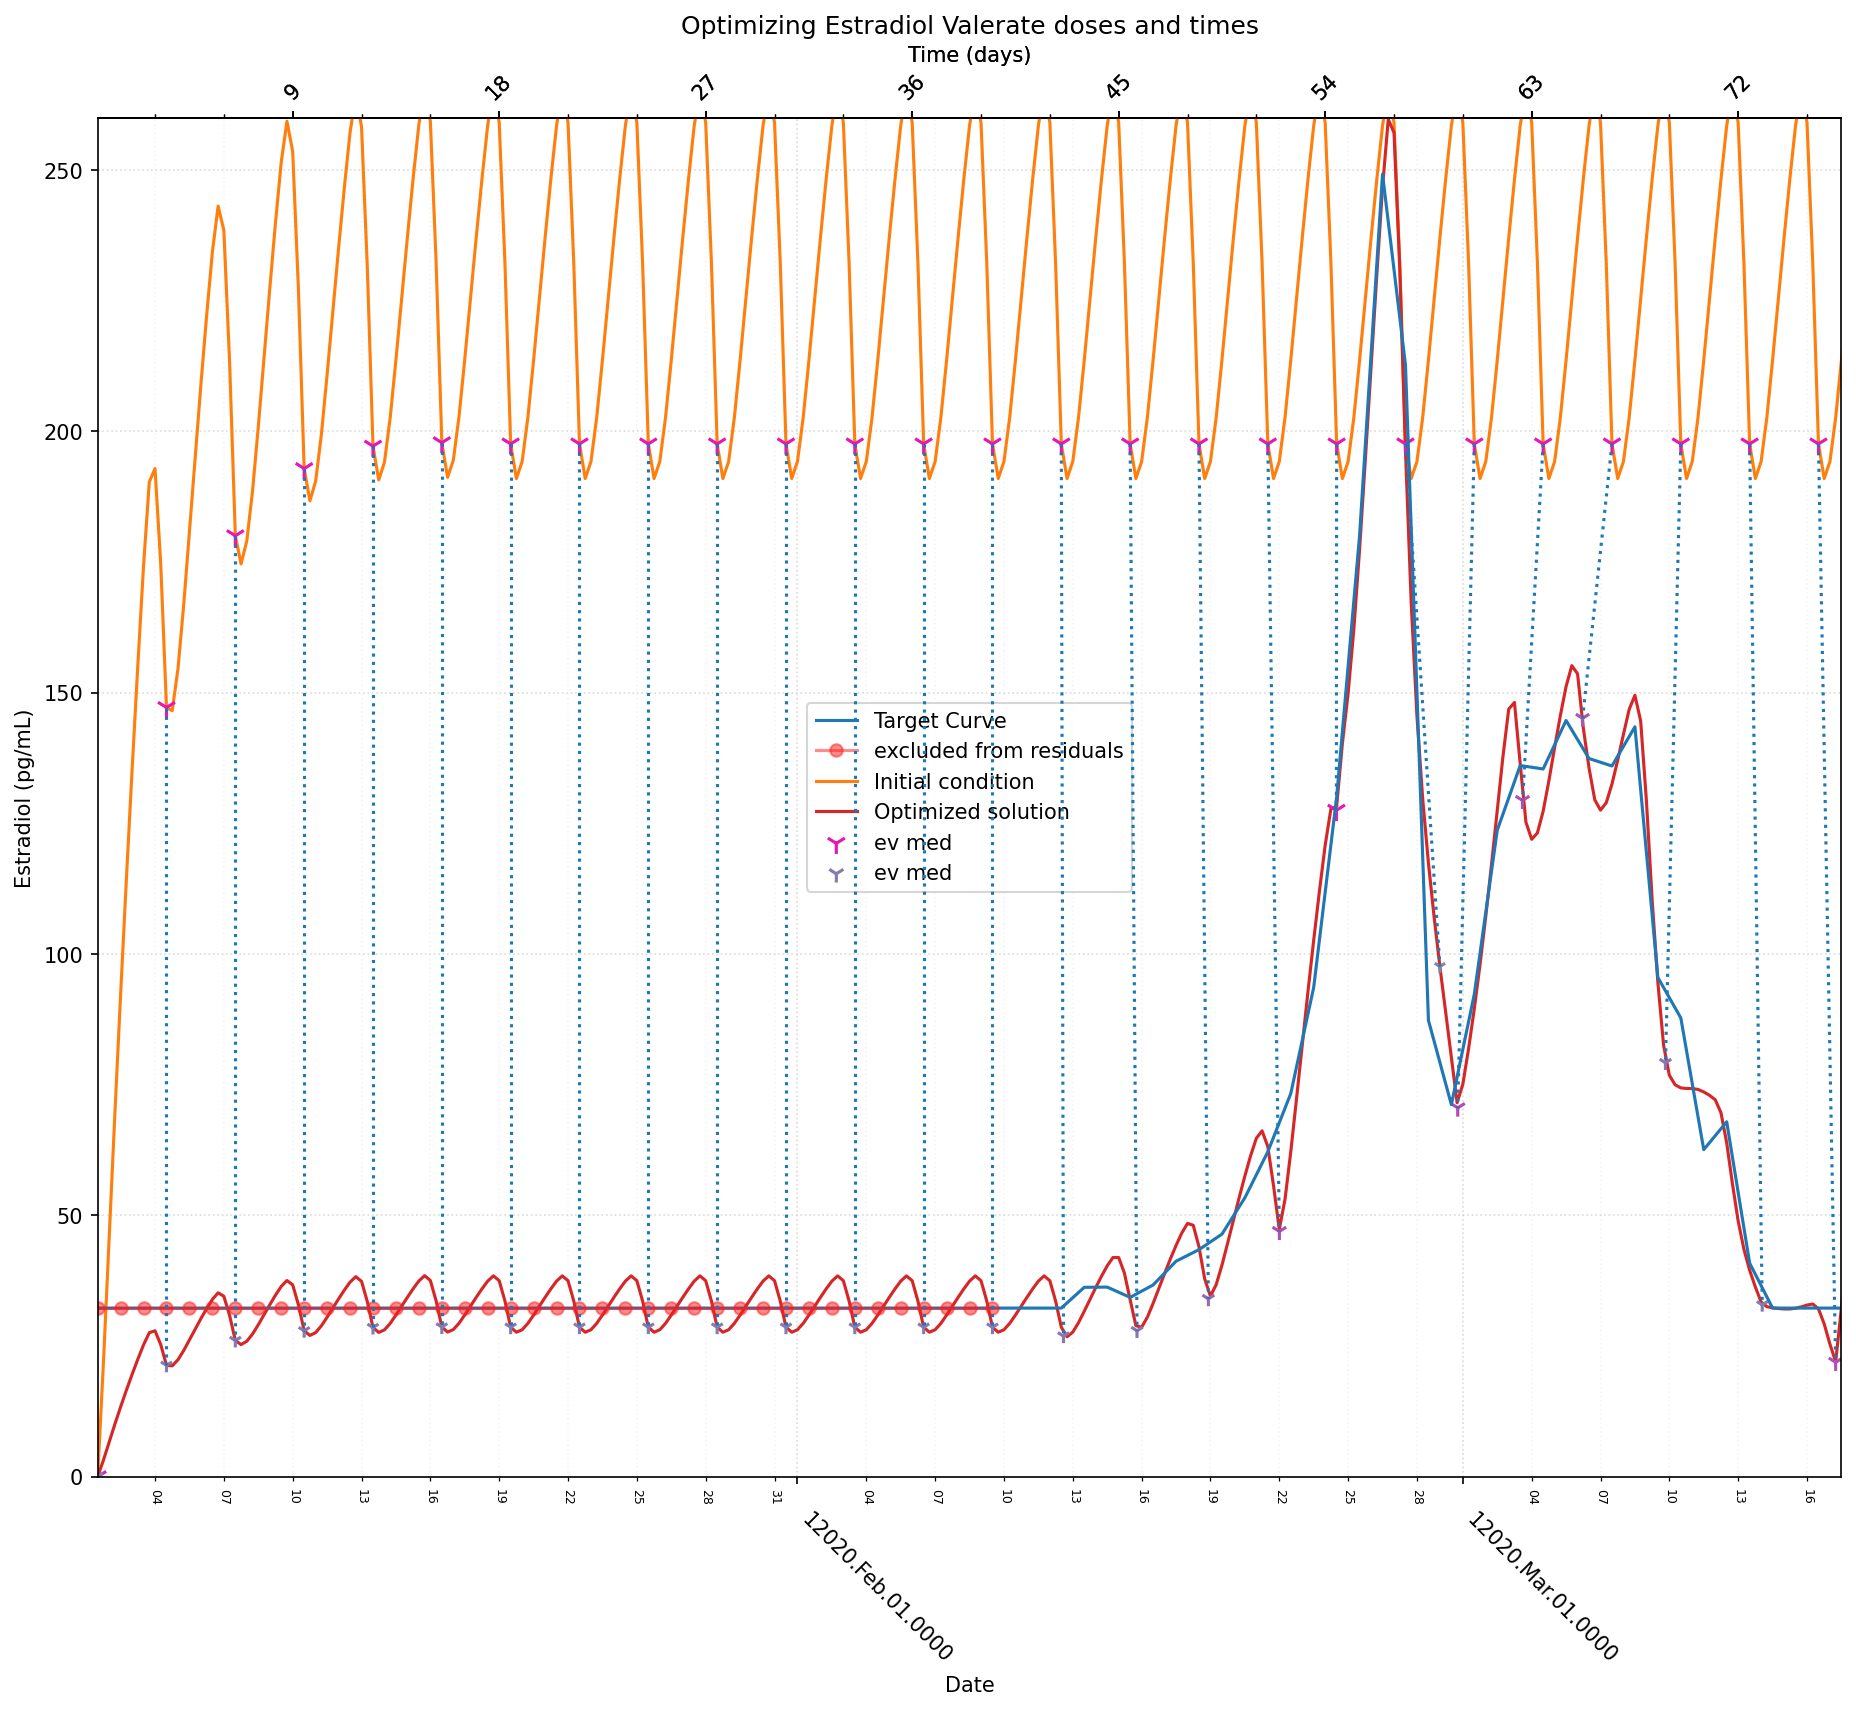

In [13]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Valerate doses and times')
ax.set_ylim(bottom=0, top=260)
ax.set_yticks(range(0, 261, 50))
fit.plotOptimizationRun(fig, ax, menstrual_fit_results["ev"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Doses:\n", menstrual_fit_results["ev"]["doses_optim"])

## Sine Wave

*try to fit blood levels to a sine wave curve*

In [14]:
cycling_start_t = 42.0 # days
sine_target_func = lambda T: int(T>=cycling_start_t) * (250.0 + 50.0*np.sin((2*math.pi/30)*(T-cycling_start_t))) +\
                             int(T<cycling_start_t)  * (250.0)
sine_start_t = pd.to_datetime("2020")
sine_target_x = pd.date_range(sine_start_t, sine_start_t + pd.to_timedelta(90.0, unit='D'), freq='18H')
sine_target_y = np.array([sine_target_func(pharma.timeDeltaToDays(T - sine_target_x[0])) for T in sine_target_x])

sine_target = pd.Series(sine_target_y, index=sine_target_x)
sine_results = fit.emptyResults()

### Least Squares (Estradiol Cypionate, optimizing doses)

Works ok, doesn't find a great solution right now.

In [17]:
sine_results["ec_doses"] = fit.initializeFit(
    pharma.createDosesCycle("ec", 90.0, '3D', start_date="2020"),
    calibrated_medications,
    sine_target,
    dose_bounds=(0.0, 5.0),
    time_bounds='fixed')
fit.runLeastSquares(
    sine_results["ec_doses"],
    max_nfev=35,
    ftol=1e-3,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2027e+06                                    2.45e+05    
       1              2         9.7434e+05      1.23e+06       5.48e+00       1.22e+05    
       2              3         2.8841e+05      6.86e+05       5.87e+00       2.82e+04    
       3              4         1.7220e+05      1.16e+05       2.62e+00       6.76e+03    
       4              5         1.5014e+05      2.21e+04       1.76e+00       1.62e+03    
       5              6         1.4571e+05      4.42e+03       1.10e+00       3.51e+02    
       6              7         1.4491e+05      8.08e+02       8.20e-01       7.55e+01    
       7              8         1.4477e+05      1.39e+02       5.70e-01       1.79e+01    
`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 2.2027e+06, final cost 1.4477e+05, first-order optimality 1.79e+01.


Optimized Doses:
                  dose medication
2020-01-01      5.000         ec
2020-01-04      5.000         ec
2020-01-07      4.999         ec
2020-01-10      4.589         ec
2020-01-13      2.794         ec
2020-01-16      3.513         ec
2020-01-19      3.166         ec
2020-01-22      3.048         ec
2020-01-25      3.143         ec
2020-01-28      3.340         ec
2020-01-31      3.430         ec
2020-02-03      3.480         ec
2020-02-06      3.392         ec
2020-02-09      3.724         ec
2020-02-12      4.869         ec
2020-02-15      4.757         ec
2020-02-18      3.858         ec
2020-02-21      2.956         ec
2020-02-24      2.223         ec
2020-02-27      1.836         ec
2020-03-01      2.058         ec
2020-03-04      2.777         ec
2020-03-07      3.844         ec
2020-03-10      4.753         ec
2020-03-13      4.855         ec
2020-03-16      4.806         ec
2020-03-19      4.092         ec
2020-03-22      2.912         ec
2020-03-25      2.104    

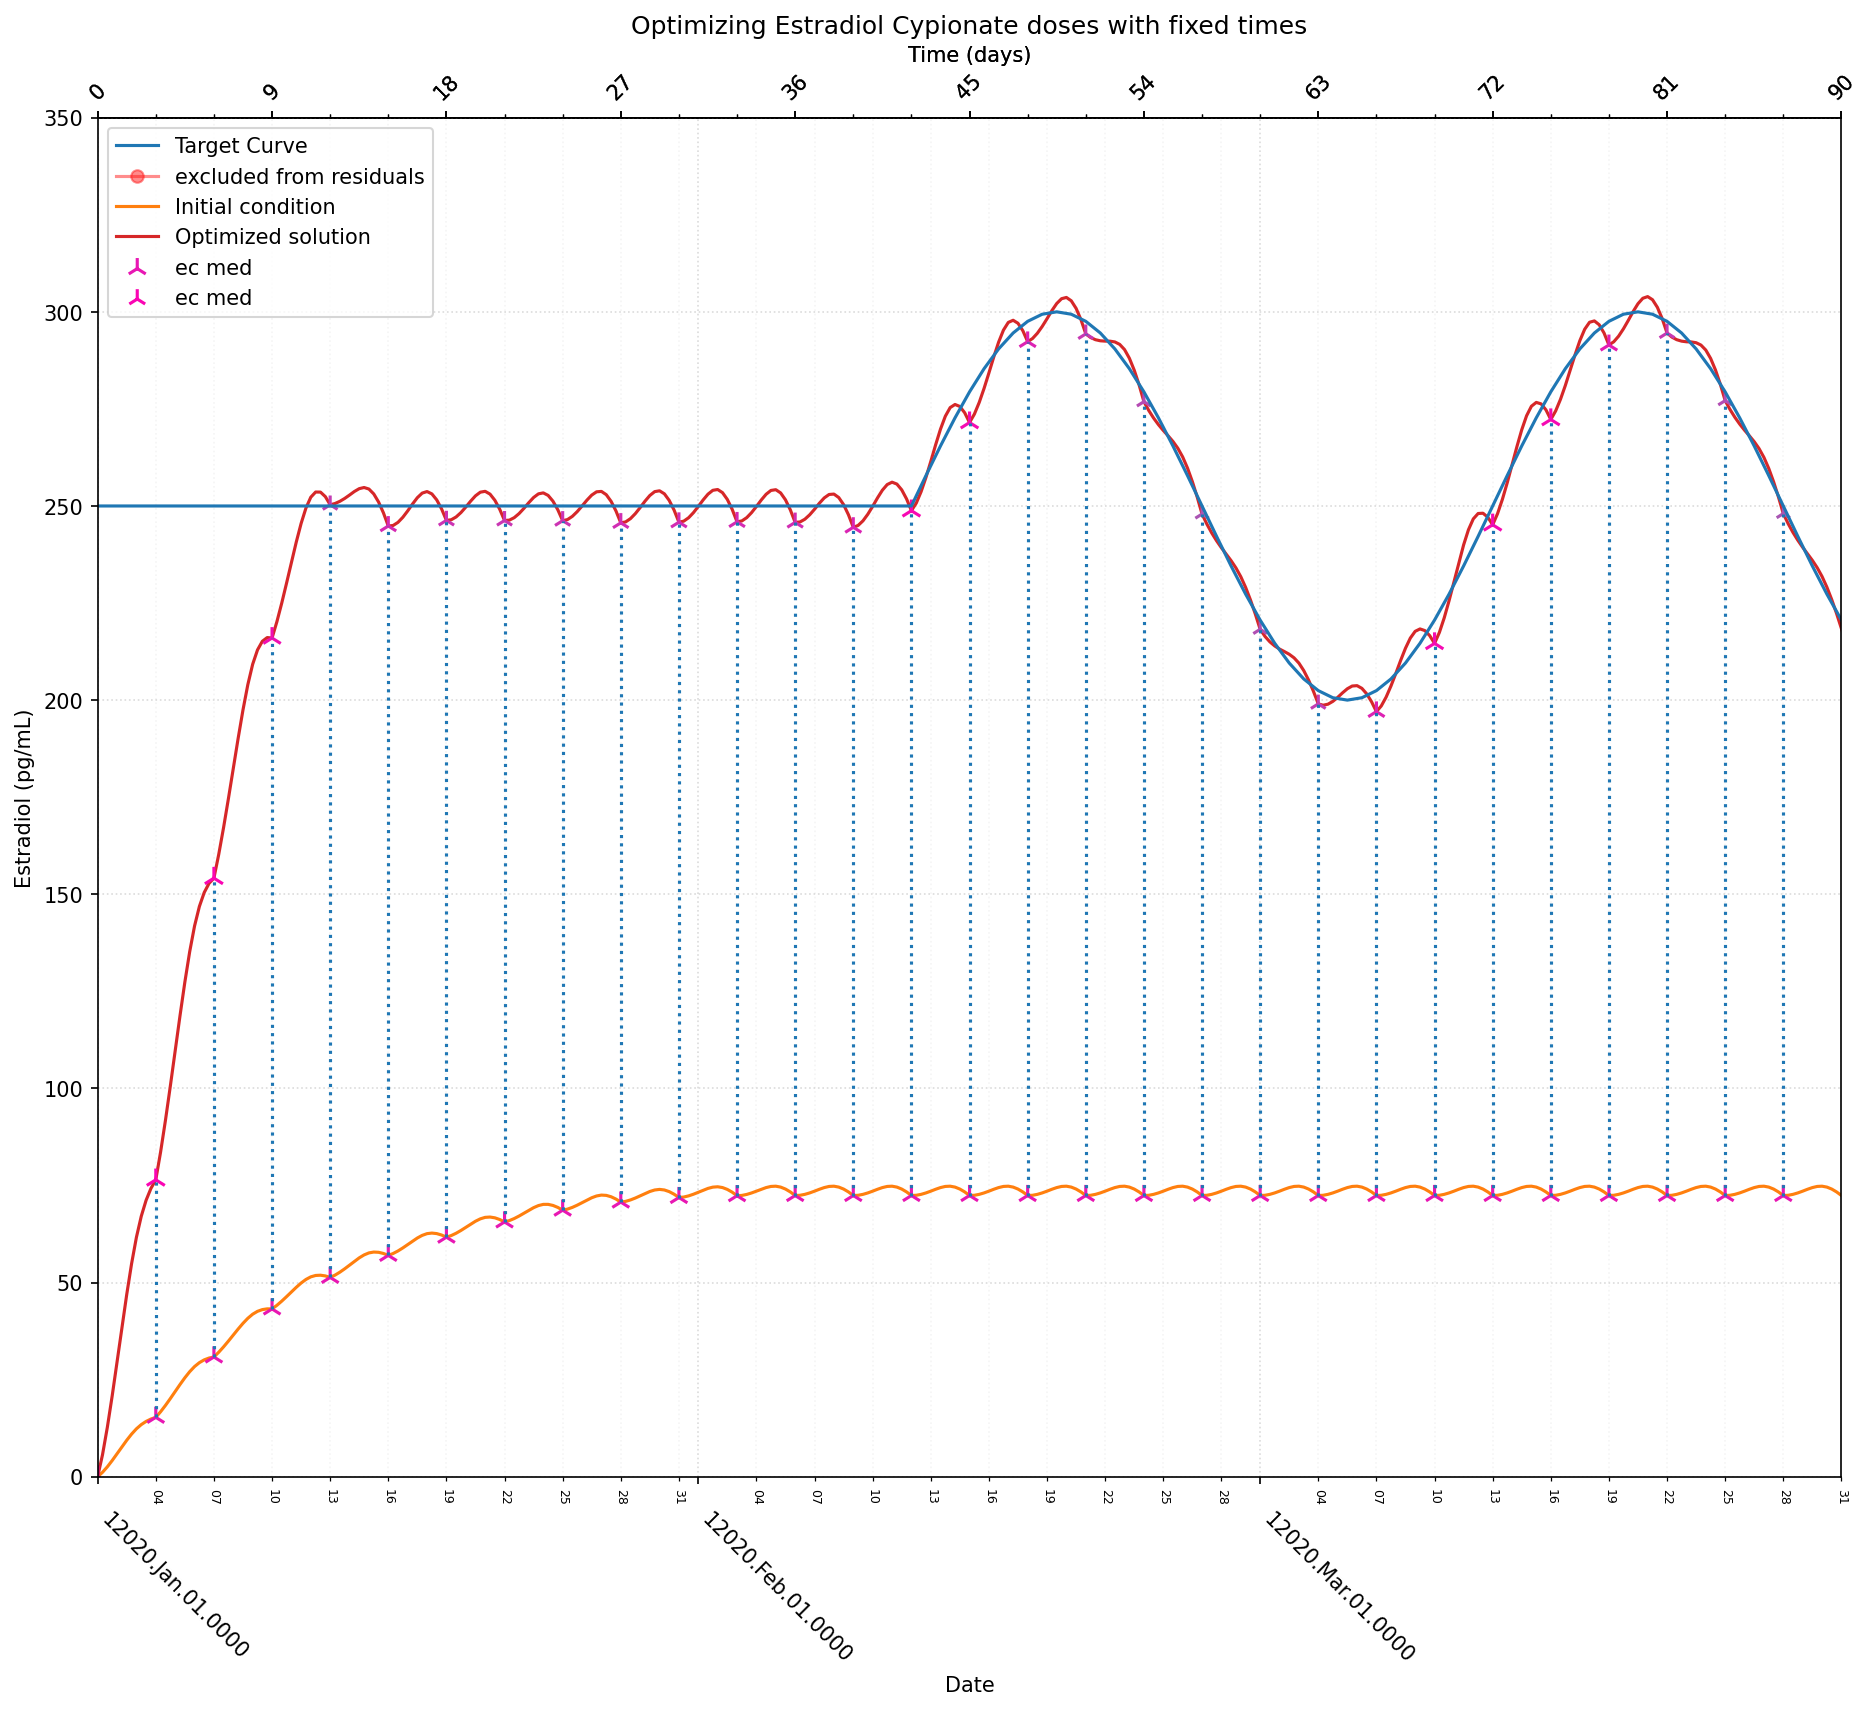

In [18]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Cypionate doses with fixed times')
ax.set_ylim(bottom=0, top=350)
ax.set_yticks(range(0, 351, 50))
fit.plotOptimizationRun(fig, ax, sine_results["ec_doses"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Doses:\n", sine_results["ec_doses"]["doses_optim"])

### Least Squares (Estradiol Cypionate, Doses & Times)

This works awesome!

In [19]:
doses = pharma.createDosesCycle("ec", 90.0, '3D', start_date="2020")
sine_results["ec_doses_and_times"] = fit.initializeFit(
    doses,
    calibrated_medications,
    sine_target,
    dose_bounds=(0.0, 5.0),
    time_bounds=['fixed'] + (len(doses)-1)*['midpoints'])
fit.runLeastSquares(
    sine_results["ec_doses_and_times"],
    max_nfev=30,
    ftol=1e-3,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2027e+06                                    2.45e+05    
       1              2         5.5419e+05      1.65e+06       8.46e+00       8.44e+04    
       2              3         1.8395e+05      3.70e+05       5.65e+00       2.11e+04    
       3              4         1.2579e+05      5.82e+04       2.02e+00       5.10e+03    
       4              5         1.1611e+05      9.68e+03       8.52e-01       1.08e+03    
       5              6         1.1411e+05      2.00e+03       6.94e-01       2.39e+02    
       6              7         1.1372e+05      3.89e+02       7.35e-01       1.05e+02    
       7              8         1.1369e+05      3.51e+01       3.82e-01       3.04e+01    
`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 2.2027e+06, final cost 1.1369e+05, first-order optimality 3.04e+01.


Optimized Doses:
                                     dose medication
2020-01-01 00:00:00.000000000      5.000         ec
2020-01-02 12:00:00.000000000      5.000         ec
2020-01-05 12:00:00.003887999      5.000         ec
2020-01-08 12:01:24.377980800      3.935         ec
2020-01-11 22:40:46.890105600      3.834         ec
2020-01-15 01:24:19.956124800      3.557         ec
2020-01-18 09:58:21.900777600      3.418         ec
2020-01-21 18:48:01.452355200      3.464         ec
2020-01-25 02:55:54.370934400      3.496         ec
2020-01-28 06:19:31.141804800      3.434         ec
2020-01-31 07:19:17.862758400      3.500         ec
2020-02-03 07:21:18.687455999      3.503         ec
2020-02-06 06:47:28.521427200      3.396         ec
2020-02-09 04:12:37.136534400      3.168         ec
2020-02-11 21:32:47.886144000      4.669         ec
2020-02-14 11:56:53.993414400      4.126         ec
2020-02-17 03:41:51.749606400      3.690         ec
2020-02-20 00:52:19.131456000      3.260      

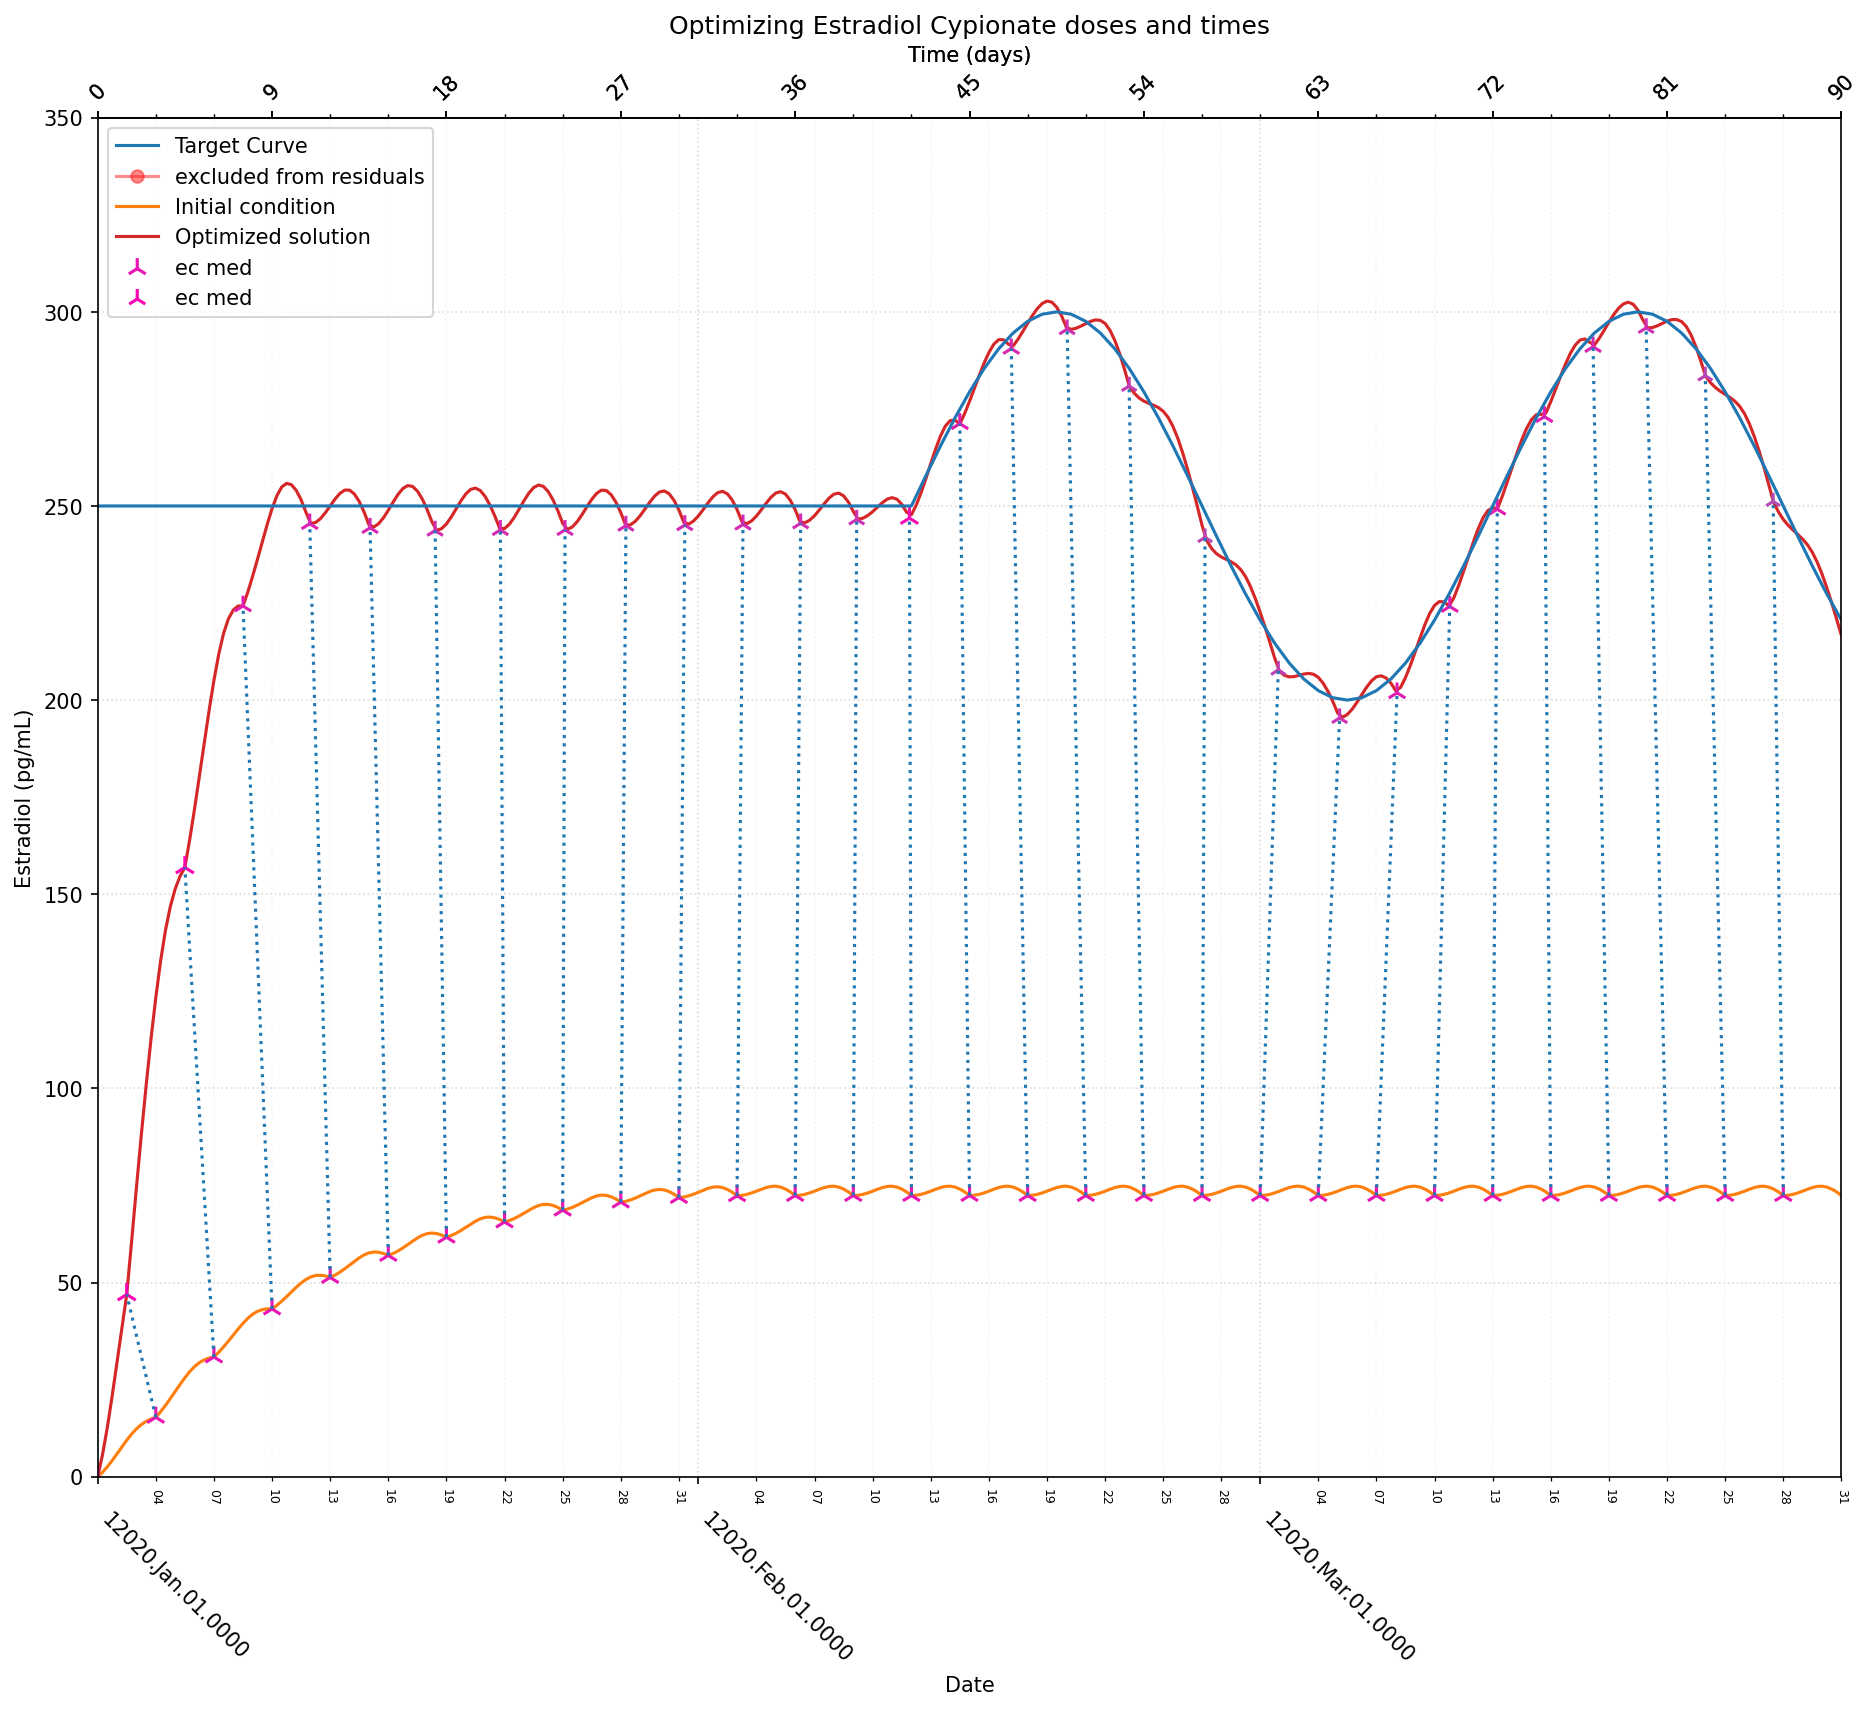

In [20]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Cypionate doses and times')
ax.set_ylim(bottom=0, top=350)
ax.set_yticks(range(0, 351, 50))
fit.plotOptimizationRun(fig, ax, sine_results["ec_doses_and_times"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Doses:\n", sine_results["ec_doses_and_times"]["doses_optim"])

### Least Squares (Estradiol Valerate, Doses & Times)

At reasonable injection schedules, EV just really doesn't work for doing any kind of cycling. You can do it alright if you inject more frequently than the single-dose peak ($\tau \lt t_{max}$), but the smoother curve of Estradiol Cypionate makes it more suitable for this use.

In [21]:
doses = pharma.createDosesCycle("ev", 90.0, '3D', start_date="2020")
sine_results["ev_doses_and_times"] = fit.initializeFit(
    doses,
    calibrated_medications,
    sine_target,
    dose_bounds=(0.0, 5.0),
    time_bounds=['fixed'] + (len(doses)-1)*['midpoints'])
fit.runLeastSquares(
    sine_results["ev_doses_and_times"],
    max_nfev=25,
    ftol=1e-3,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9672e+05                                    2.87e+05    
       1              2         8.2900e+04      1.14e+05       1.37e+00       3.77e+04    
       2              3         8.0726e+04      2.17e+03       2.95e-01       1.30e+03    
       3              4         8.0669e+04      5.69e+01       6.17e-02       1.14e+02    
`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 1.9672e+05, final cost 8.0669e+04, first-order optimality 1.14e+02.


Optimized Doses:
                                     dose medication
2020-01-01 00:00:00.000000000      1.710         ev
2020-01-04 06:55:27.127574400      1.099         ev
2020-01-07 05:18:52.479417600      1.068         ev
2020-01-10 05:23:52.130515200      1.085         ev
2020-01-13 05:35:57.722035200      1.086         ev
2020-01-16 05:31:01.829510400      1.089         ev
2020-01-19 05:29:56.231433600      1.088         ev
2020-01-22 05:30:26.840188800      1.088         ev
2020-01-25 05:30:39.373286400      1.088         ev
2020-01-28 05:30:35.224099200      1.088         ev
2020-01-31 05:30:32.926896000      1.088         ev
2020-02-03 05:30:25.746969600      1.088         ev
2020-02-06 05:30:36.304444800      1.089         ev
2020-02-09 05:38:41.909337600      1.093         ev
2020-02-12 06:18:56.830723200      1.245         ev
2020-02-15 05:46:26.831971200      1.318         ev
2020-02-18 05:07:57.545385600      1.302         ev
2020-02-21 04:37:44.967993600      1.202      

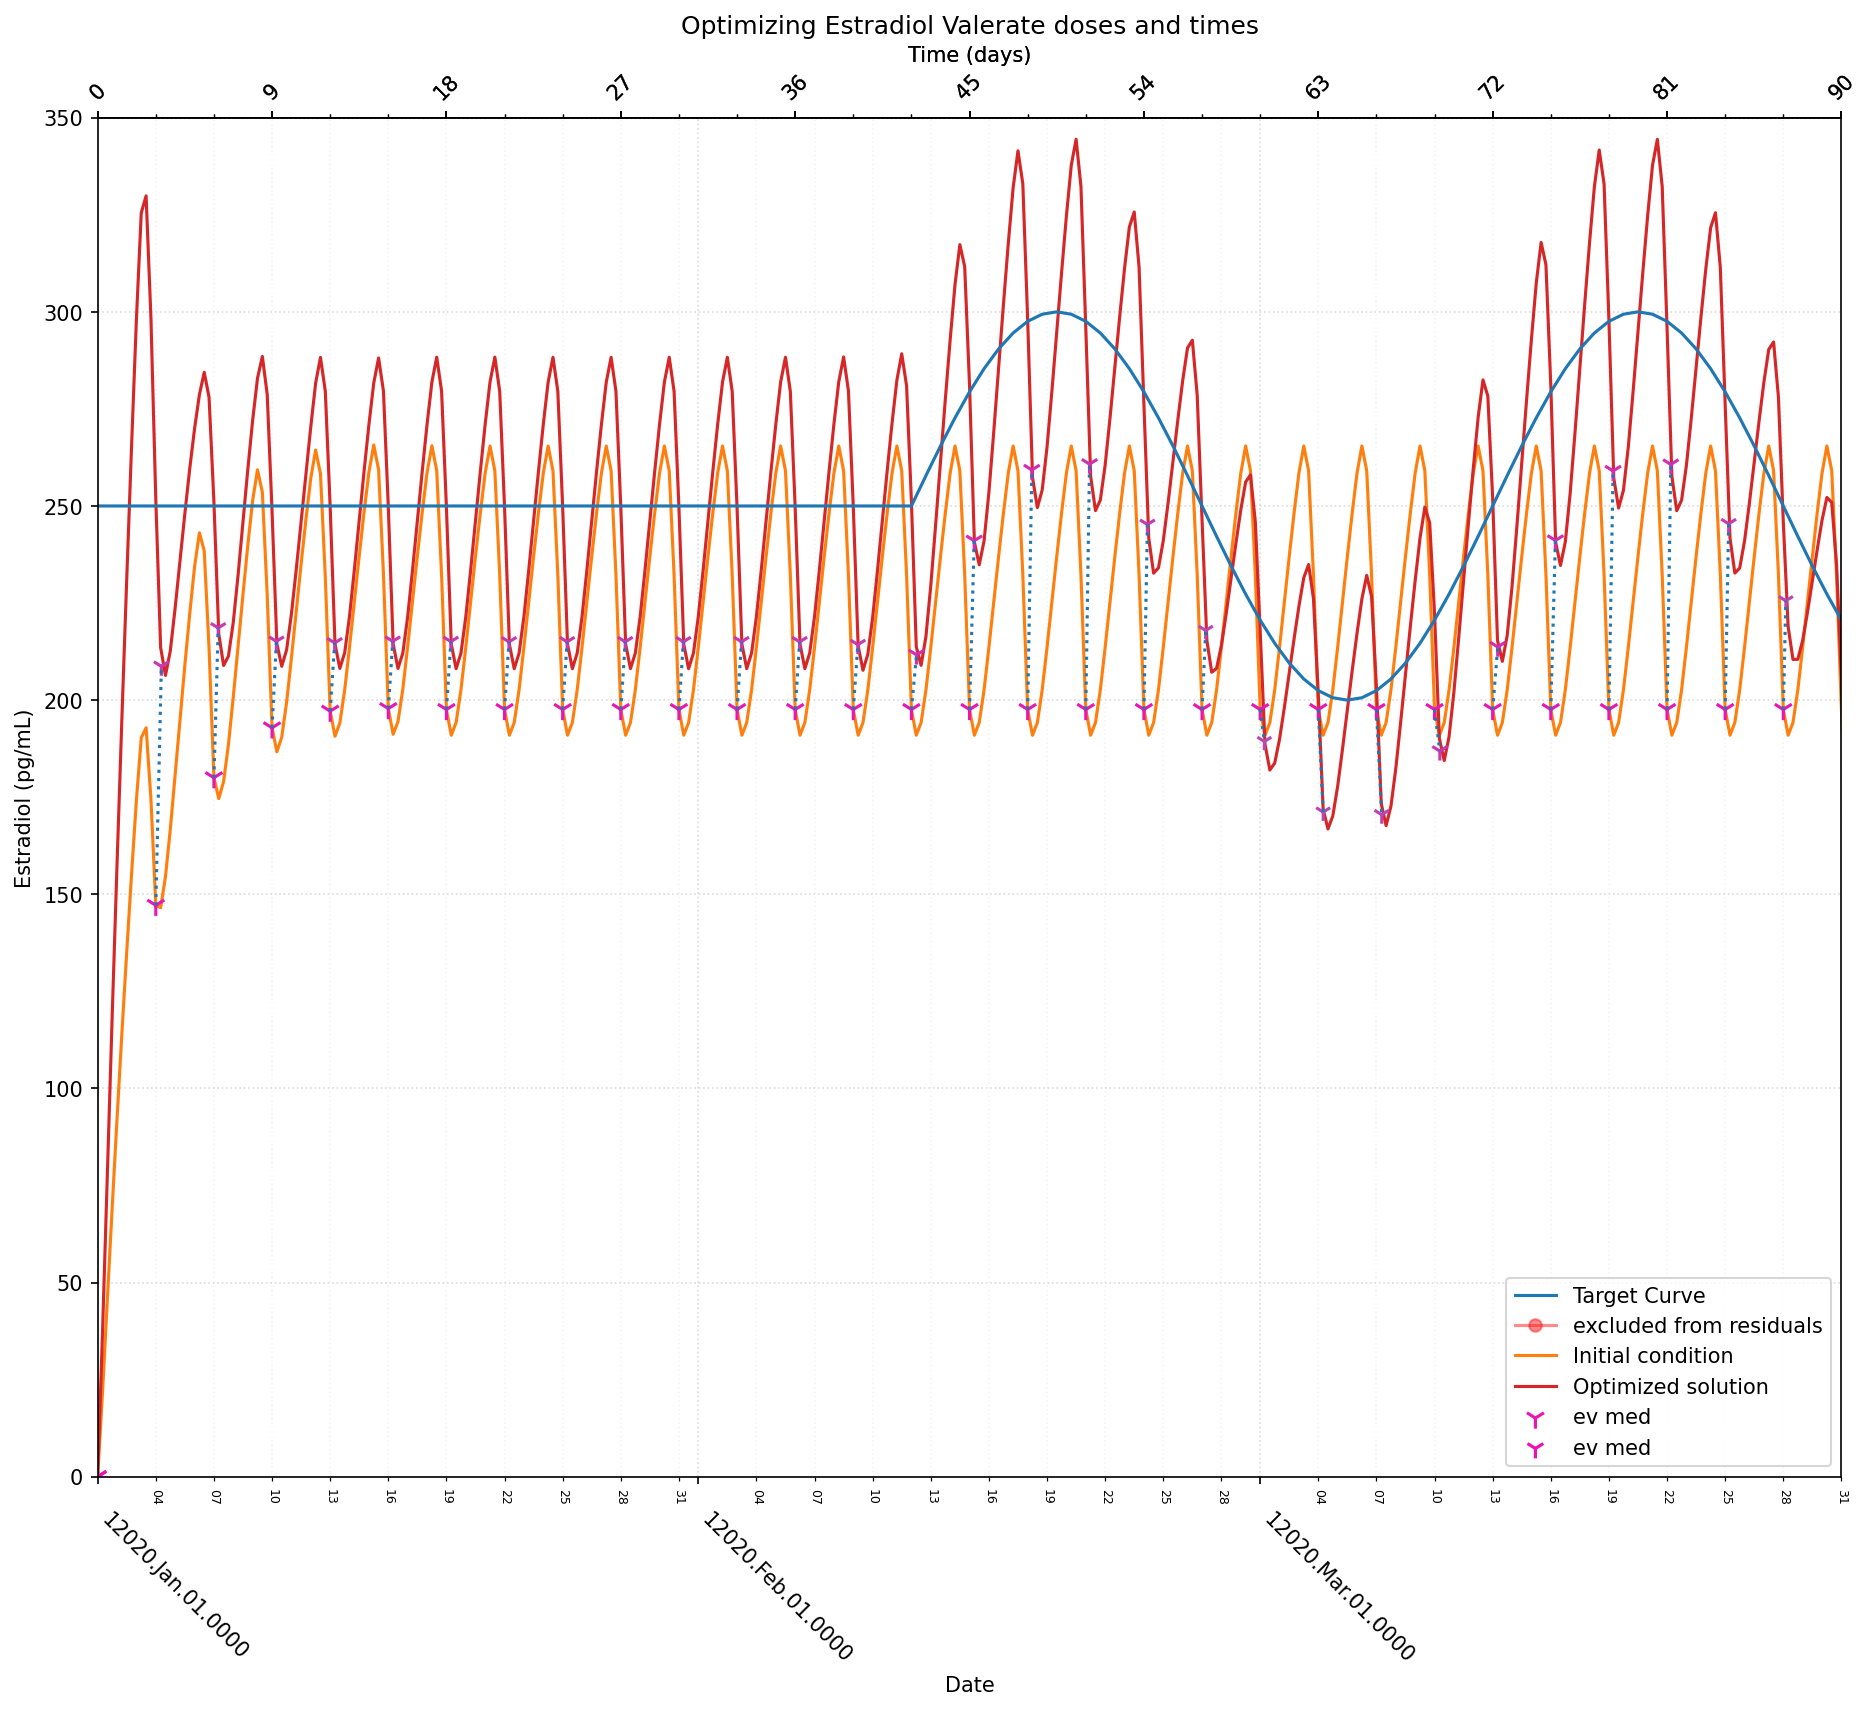

In [22]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Valerate doses and times')
ax.set_ylim(bottom=0, top=350)
ax.set_yticks(range(0, 351, 50))
fit.plotOptimizationRun(fig, ax, sine_results["ev_doses_and_times"])

with pd.option_context("display.float_format", "{:10,.3f}".format,
                       "display.max_rows", sys.maxsize):
    print("Optimized Doses:\n", sine_results["ev_doses_and_times"]["doses_optim"])

### Step func (Estradiol Cypionate, optimize doses & times)

It's a loading dose! This demonstrates the control theory intuition that, if desired, you can reach a steady state level more quickly by using several large injections to reach the target level and then reducing to a regular consistent dose. That doesn't mean it would be good for your body! But, looking purely at blood concentration levels, it's possible. The lsq solution here achieves a 150pg/mL change in level, steady-to-steady, in just 9 days (in comparison to 6 weeks for a linear, consistent increase in dose.

In [23]:
step_func = lambda T: int(T>=pd.to_datetime('1970-02-01')) * (250.0) +\
                       int(T<pd.to_datetime('1970-02-01'))  * (100.0)
step_target_x = pd.date_range(0, pd.to_datetime(62.0, unit='D'), freq='12H')
step_target_y = np.array([step_func(T) for T in step_target_x])

step_target = pd.Series(step_target_y, index=step_target_x)
step_results = fit.emptyResults()

In [25]:
step_results["ec_doses_and_times"] = fit.initializeFit(
    pharma.createDosesCycle("ec", 62.0, '3D'),
    calibrated_medications,
    step_target,
    dose_bounds=(0.0, 5.0),
    time_bounds=7*['fixed'] + 8*['midpoints'] + 6*['fixed'])
fit.runLeastSquares(
    step_results["ec_doses_and_times"],
    max_nfev=35,
    ftol=1e-3,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0659e+06                                    3.09e+05    
       1              2         1.8445e+05      8.81e+05       6.32e+00       7.00e+04    
       2              3         4.6727e+04      1.38e+05       3.21e+00       1.57e+04    
       3              4         2.6336e+04      2.04e+04       1.88e+00       3.57e+03    
       4              5         2.2877e+04      3.46e+03       1.43e+00       3.93e+03    
       5              6         2.1792e+04      1.09e+03       1.31e+00       3.01e+03    
       6              7         2.1160e+04      6.33e+02       9.18e-01       2.16e+03    
       7              9         2.1091e+04      6.86e+01       2.15e-01       4.76e+02    
       8             10         2.1040e+04      5.07e+01       1.23e-01       2.03e+02    
       9             11         2.0984e+04      5.69e+01       2.24e-01       2.63e+02    

Optimized Doses:
                                     dose medication
1970-01-01 00:00:00.000000000      5.000         ec
1970-01-04 00:00:00.000000000      1.604         ec
1970-01-07 00:00:00.000000000      0.669         ec
1970-01-10 00:00:00.000000000      1.773         ec
1970-01-13 00:00:00.000000000      1.408         ec
1970-01-16 00:00:00.000000000      1.103         ec
1970-01-19 00:00:00.000000000      1.331         ec
1970-01-22 18:58:38.638185600      1.665         ec
1970-01-26 08:51:41.308531200      1.225         ec
1970-01-29 11:59:59.999654400      4.998         ec
1970-01-30 13:25:02.568604800      5.000         ec
1970-02-01 12:00:00.347414400      3.017         ec
1970-02-05 13:55:49.814774400      3.572         ec
1970-02-08 17:06:16.996607999      4.000         ec
1970-02-11 16:02:23.477683200      3.405         ec
1970-02-15 00:00:00.000000000      3.188         ec
1970-02-18 00:00:00.000000000      3.215         ec
1970-02-21 00:00:00.000000000      3.330      

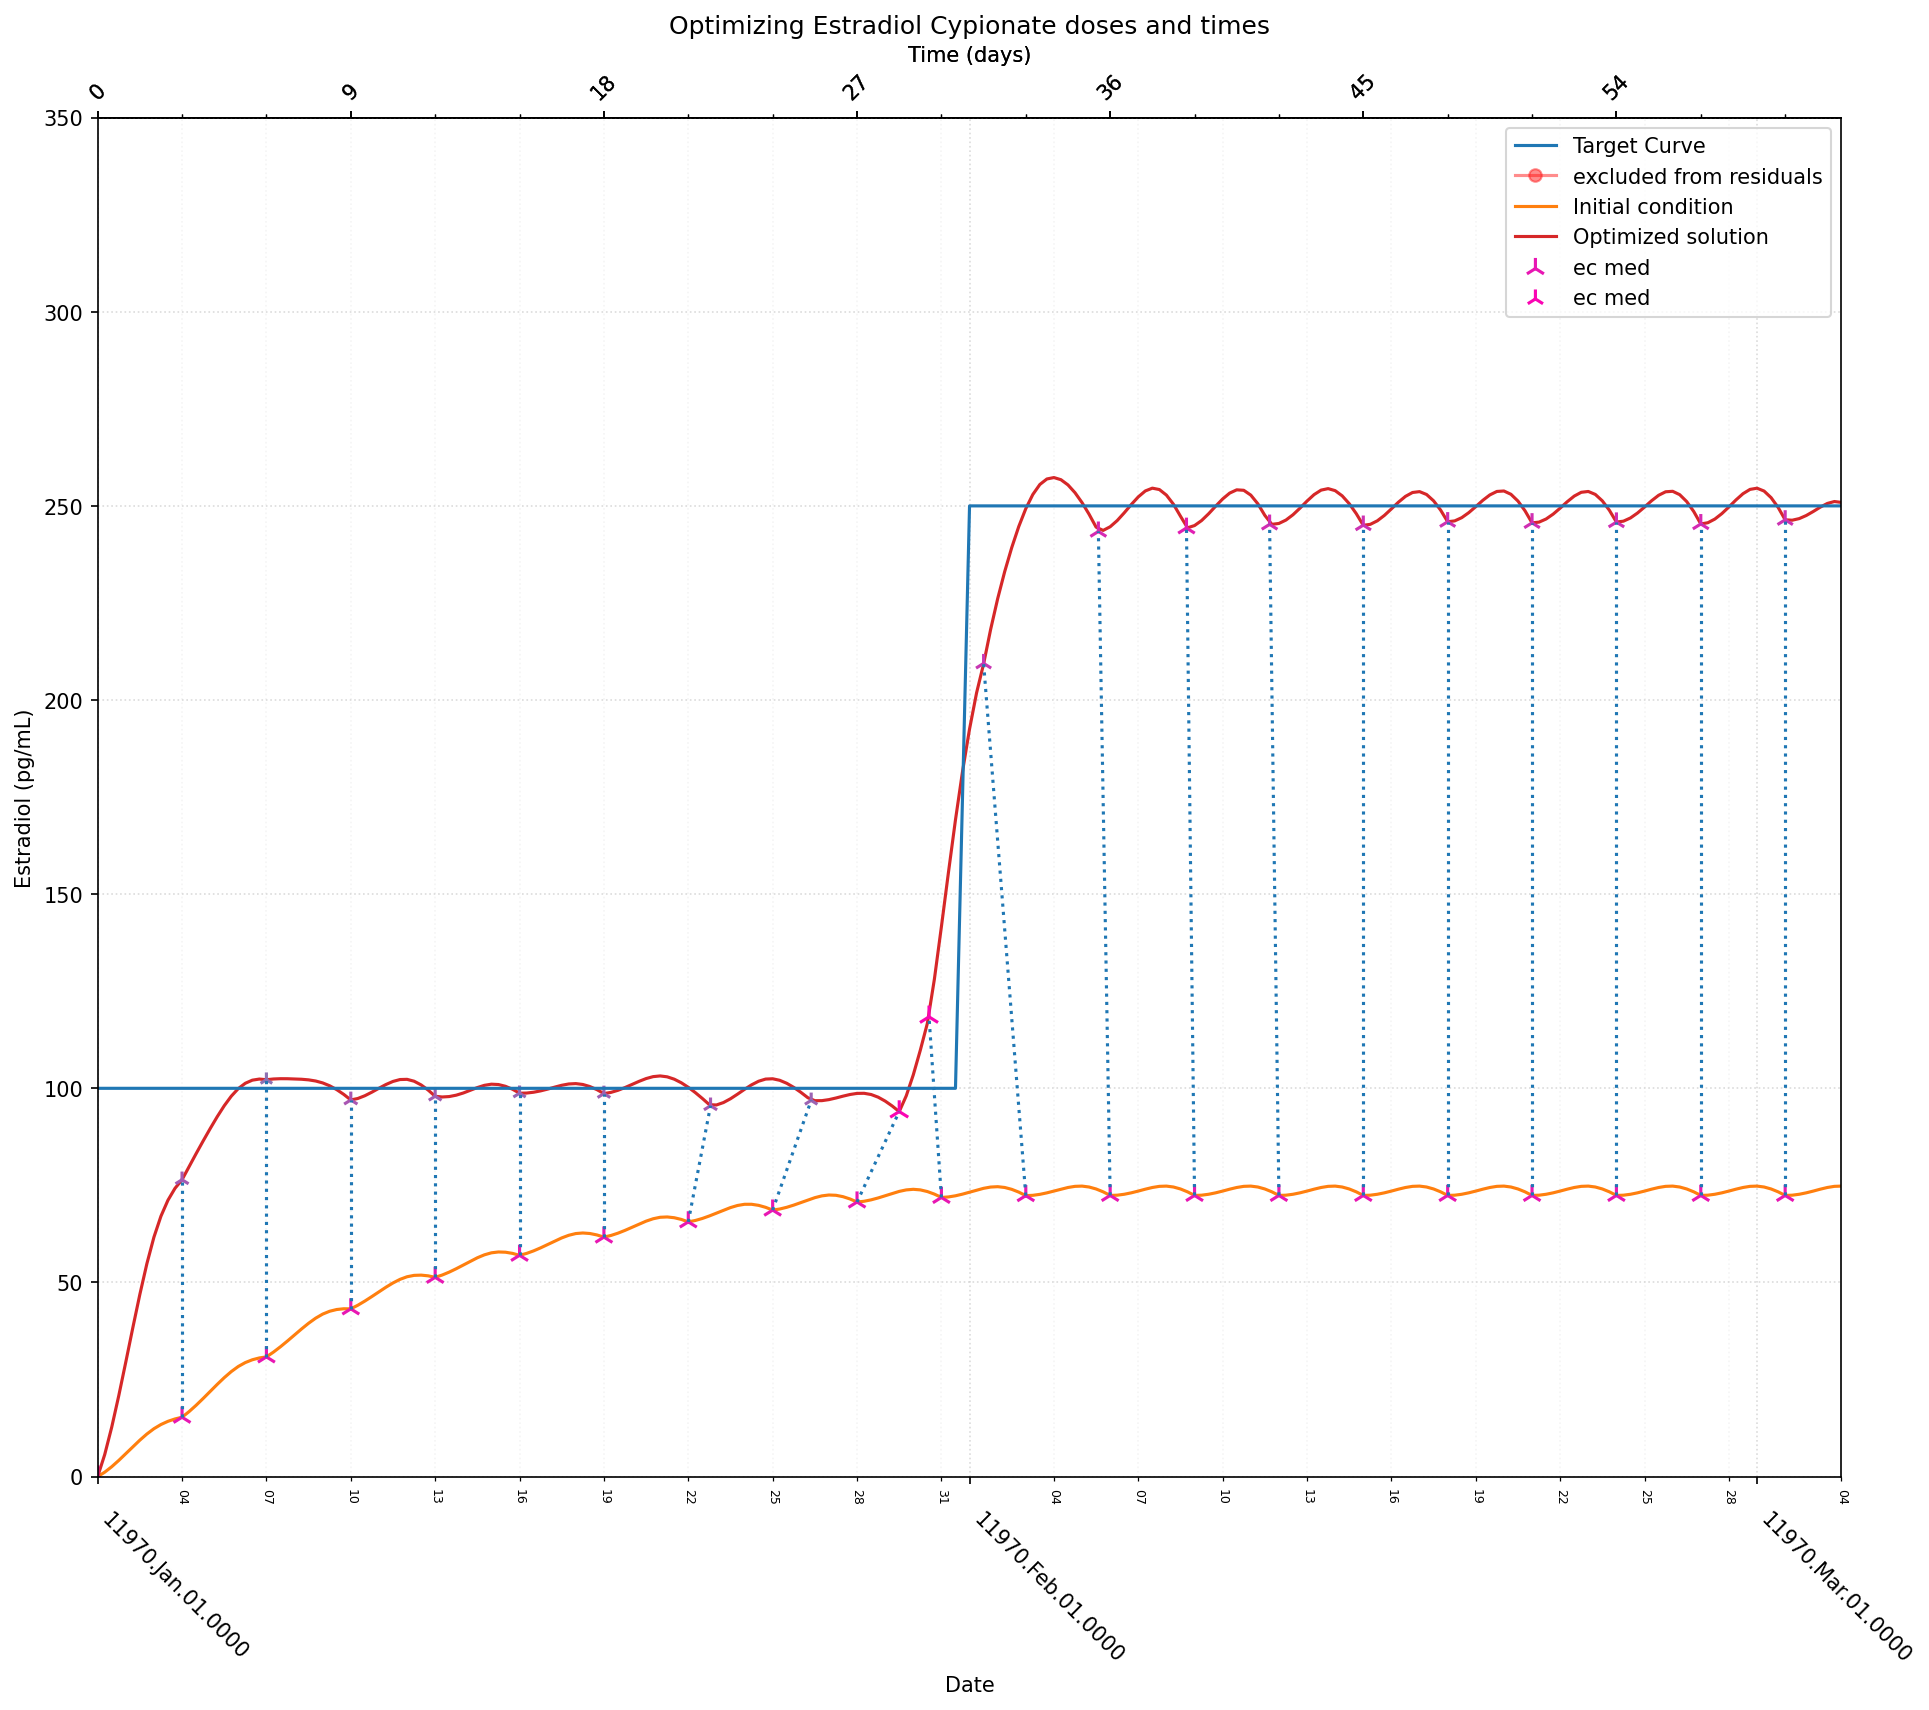

In [26]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Cypionate doses and times')
ax.set_ylim(bottom=0, top=350)
ax.set_yticks(range(0, 351, 50))
fit.plotOptimizationRun(fig, ax, step_results["ec_doses_and_times"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Doses:\n", step_results["ec_doses_and_times"]["doses_optim"])